In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [3]:
#load in data
df=pd.read_csv("heart.csv")

In [3]:
#explore data,separating discrete and continuous features
df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


In [4]:
df.dtypes

age           int64
sex           int64
cp            int64
trestbps      int64
chol          int64
fbs           int64
restecg       int64
thalach       int64
exang         int64
oldpeak     float64
slope         int64
ca            int64
thal          int64
target        int64
dtype: object

In [5]:
continuous=df.select_dtypes("float")
continuous.head()

,oldpeak
0,2.3
1,3.5
2,1.4
3,0.8
4,0.6


In [6]:
discrete=df.select_dtypes("integer")
discrete.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,0,0,1,1
1,37,1,2,130,250,0,1,187,0,0,0,2,1
2,41,0,1,130,204,0,0,172,0,2,0,2,1
3,56,1,1,120,236,0,1,178,0,2,0,2,1
4,57,0,0,120,354,0,1,163,1,2,0,2,1


<function matplotlib.pyplot.show(close=None, block=None)>

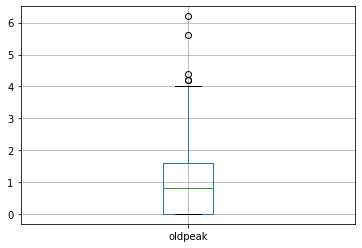

In [7]:
#outliers in the continuous features and solving using IQR
continuous.boxplot(column='oldpeak')
plt.show

In [8]:
continuous_iqr=continuous
Q1=continuous_iqr.quantile(0.25)
Q3=continuous_iqr.quantile(0.75)
IQR=Q3-Q1
print(IQR)


oldpeak    1.6
dtype: float64


In [9]:
threshold=3
(continuous_iqr<(Q1-threshold*IQR))|(continuous_iqr>(Q3+threshold*IQR))


,oldpeak
0,False
1,False
2,False
3,False
4,False
...,...
298,False
299,False
300,False
301,False


In [10]:
continuous_iqr.shape

(303, 1)

In [11]:
continuous_iqr_clean=(continuous_iqr<(Q1-threshold*IQR))|(continuous_iqr>(Q3+threshold*IQR)).any(axis=1)

In [12]:
continuous_iqr_clean.shape

(303, 304)

In [13]:
# Create X (all the feature columns)
x = df.drop("target", axis=1)

# Create y (the target column)
y = df["target"]

In [14]:
x.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2


In [15]:
y.head()

0    1
1    1
2    1
3    1
4    1
Name: target, dtype: int64

In [16]:
#Backward Elimination
import statsmodels.api as sm
cols = list(x.columns)
pmax = 1
while (len(cols)>0):
    p= []
    x_1 = x[cols]
    x_1 = sm.add_constant(x_1)
    model = sm.OLS(y,x_1).fit()
    p = pd.Series(model.pvalues.values[1:],index = cols)      
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax>0.05):
        cols.remove(feature_with_p_max)
    else:
        break
selected_features_BE = cols
print(selected_features_BE)

['sex', 'cp', 'thalach', 'exang', 'oldpeak', 'ca', 'thal']


In [21]:

#slice data and scale features
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(x,y, shuffle=True)
from sklearn.preprocessing import StandardScaler
stdscalar = StandardScaler()
train_x = stdscalar.fit_transform(train_x)
test_x = stdscalar.transform(test_x)

In [19]:
train_x

array([[-1.26697509, -1.51322671, -0.92353285, ..., -0.66860321,
        -0.72053069,  1.14193067],
       [ 0.02950881, -1.51322671,  0.03373636, ..., -0.66860321,
        -0.72053069, -0.53044521],
       [ 0.89383141,  0.66083951,  1.94827479, ..., -2.28320884,
        -0.72053069, -2.20282109],
       ...,
       [-1.05089444, -1.51322671,  0.03373636, ..., -0.66860321,
        -0.72053069, -0.53044521],
       [-0.94285412, -1.51322671,  0.03373636, ...,  0.94600242,
        -0.72053069, -0.53044521],
       [-0.94285412,  0.66083951, -0.92353285, ...,  0.94600242,
        -0.72053069,  1.14193067]])

In [22]:
#data balancing
y.head(), y.value_counts()

(0    1
 1    1
 2    1
 3    1
 4    1
 Name: target, dtype: int64,
 1    165
 0    138
 Name: target, dtype: int64)

In [23]:
#classification methods
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
k_fold = KFold(n_splits=12, shuffle=True, random_state=0)


In [24]:
#RandomForestClassifier
clf = RandomForestClassifier(n_estimators=10)
scoring = 'accuracy'
score = cross_val_score(clf, train_x, train_y, cv=k_fold, n_jobs=1, scoring=scoring)
round(np.mean(score)*100, 2)


80.6

In [25]:
#DecisionTreeClassifier
clf = DecisionTreeClassifier()
scoring = 'accuracy'
score = cross_val_score(clf, train_x, train_y, cv=k_fold, n_jobs=1, scoring=scoring)
round(np.mean(score)*100, 2)

77.12

In [26]:
#GaussianNB
clf = GauNaive BayesssianNB()
scoring = 'accuracy'
score = cross_val_score(clf, train_x, train_y, cv=k_fold, n_jobs=1, scoring=scoring)
round(np.mean(score)*100, 2)

82.38

In [28]:
#GradientBoostingClassifier
clf = GradientBoostingClassifier()
scoring = 'accuracy'
score = cross_val_score(clf, train_x, train_y, cv=k_fold, n_jobs=1, scoring=scoring)
round(np.mean(score)*100, 2)

78.83

In [26]:
from sklearn. model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
parameters=[{'penalty':['l1','l2'],'C':[0.1,0.4,0.5],'random_state':[0]}]
search = GridSearchCV(gnb, parameters, scoring='accuracy', n_jobs=-1, )
result = search.fit(train_x,train_y)
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

ValueError: Invalid parameter c for estimator GaussianNB(). Check the list of available parameters with `estimator.get_params().keys()`.

In [27]:
#redefine the module
clf = GaussianNB()
clf.fit(train_x, train_y)

GaussianNB()

In [28]:
predictions = clf.predict(test_x)
list_of_values = list(zip(predictions, test_y.values))
status = []
for x, y in list_of_values:
    status.append(x == y)
list_of_values = list(zip(predictions, test_y.values, status))
final_df = pd.DataFrame(list_of_values, columns=['Predicted', 'Actual', "Status"])

In [29]:
final_df.head()

,Predicted,Actual,Status
0,0,0,True
1,1,1,True
2,0,0,True
3,0,0,True
4,1,0,False


In [33]:

clf_probs = clf.predict_proba(test_x)


In [34]:
clf_probs

array([[9.99996923e-01, 3.07709945e-06],
       [2.39747014e-01, 7.60252986e-01],
       [9.96943330e-01, 3.05666963e-03],
       [1.00000000e+00, 8.83628076e-14],
       [2.47470876e-01, 7.52529124e-01],
       [1.46197846e-01, 8.53802154e-01],
       [1.28590281e-02, 9.87140972e-01],
       [9.93449180e-01, 6.55081956e-03],
       [3.45177524e-01, 6.54822476e-01],
       [5.19208486e-01, 4.80791514e-01],
       [9.99993812e-01, 6.18775898e-06],
       [4.45938566e-03, 9.95540614e-01],
       [1.12778333e-03, 9.98872217e-01],
       [9.99955498e-01, 4.45015556e-05],
       [9.64322044e-01, 3.56779559e-02],
       [6.78966967e-03, 9.93210330e-01],
       [1.84575536e-01, 8.15424464e-01],
       [8.36187184e-01, 1.63812816e-01],
       [7.51807810e-02, 9.24819219e-01],
       [7.78619939e-01, 2.21380061e-01],
       [9.00248408e-01, 9.97515925e-02],
       [9.99988638e-01, 1.13622533e-05],
       [9.96455688e-01, 3.54431191e-03],
       [8.18600512e-01, 1.81399488e-01],
       [1.739711

In [35]:
clf_probs = clf_probs[:, 1]

In [41]:
from sklearn.metrics import roc_curve, roc_auc_score
clf_auc = roc_auc_score(test_y, clf_probs)

In [43]:

print('Naive Bayes: AUROC = %.3f' % (clf_auc))

Naive Bayes: AUROC = 0.884


The high AUC shows that the model is good at distinguishing between patients with disease and no disease.

In [44]:
clf_fpr, clf_tpr, _ = roc_curve(test_y, clf_probs)

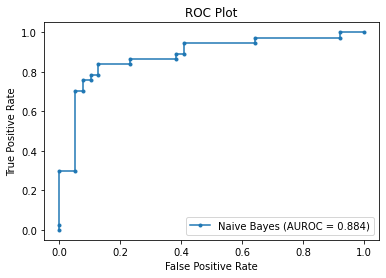

In [47]:
plt.plot(clf_fpr, clf_tpr, marker='.', label='Naive Bayes (AUROC = %0.3f)' % clf_auc)
plt.title('ROC Plot')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()